In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from pettingzoo.atari import pong_v3
import supersuit as ss
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print("Using device:", device)

True
NVIDIA GeForce RTX 5070
Using device: cuda


In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0))
print("Compute capability:", torch.cuda.get_device_capability(0))

PyTorch version: 2.7.1+cu128
CUDA available: True
Device name: NVIDIA GeForce RTX 5070
Compute capability: (12, 0)


In [ ]:
import gzip
import pickle

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512), nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        if x.dim() == 3:
            x = x.permute(2, 0, 1).unsqueeze(0)
        elif x.dim() == 4:
            x = x.permute(0, 3, 1, 2)
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((
            (state * 255).astype(np.uint8),
            action,
            reward,
            (next_state * 255).astype(np.uint8),
            done
        ))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states, dtype=np.uint8).astype(np.float32) / 255.0,
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.uint8).astype(np.float32) / 255.0,
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)
    
    def save(self, filepath):
        with gzip.open(filepath, 'wb') as f:
            pickle.dump((self.buffer, self.capacity), f)

    def load(self, filepath):
        with gzip.open(filepath, 'rb') as f:
           self.buffer, self.capacity = pickle.load(f)

def select_action(model, state, epsilon, num_actions, device):
    if random.random() < epsilon:
        return random.randrange(num_actions)
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        q_values = model(state_tensor)
    return q_values.argmax(dim=1).item()

def compute_td_loss(batch, policy_net, target_net, gamma, device):
    states, actions, rewards, next_states, dones = batch
    states = torch.tensor(states, dtype=torch.float32, device=device)
    actions = torch.tensor(actions, dtype=torch.int64, device=device)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
    next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
    dones = torch.tensor(dones, dtype=torch.float32, device=device)
    q_values = policy_net(states)
    next_q_values = target_net(next_states)
    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    max_next_q_value = next_q_values.max(1)[0]
    expected_q_value = rewards + gamma * max_next_q_value * (1 - dones)
    loss = nn.MSELoss()(q_value, expected_q_value.detach())
    return loss

class DQNAgent:
    def __init__(self, obs_shape, num_actions, device='cpu'):
        self.policy_net = DQN(obs_shape, num_actions).to(device)
        self.target_net = DQN(obs_shape, num_actions).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-4)
        self.steps_done = 0
        self.device = device
        self.num_actions = num_actions

    def select_action(self, state, epsilon):
        return select_action(self.policy_net, state, epsilon, num_actions=self.num_actions, device=self.device)

    def optimize(self, buffer, batch_size):
        if len(buffer) < batch_size:
            return
        batch = buffer.sample(batch_size)
        loss = compute_td_loss(batch, self.policy_net, self.target_net, gamma=0.99, device=self.device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
class REINFORCEPolicy(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512), nn.ReLU(),
            nn.Linear(512, num_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

class REINFORCEAgent:
    def __init__(self, input_shape, num_actions, gamma=0.99, lr=1e-3, device='cpu'):
        self.device = device
        self.gamma = gamma
        self.num_actions = num_actions
        self.model = REINFORCEPolicy(input_shape, num_actions).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.log_probs = []
        self.rewards = []

    def select_action(self, state):
        if len(self.rewards) < 75000:
            return np.random.randint(self.num_actions)
        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        state = state.permute(2, 0, 1).unsqueeze(0)

        probs = self.model(state)

        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        self.log_probs.append(dist.log_prob(action))
        return action.item()

    def store_reward(self, reward):
        self.rewards.append(reward)

    def update_policy(self):
        if not self.rewards or not self.log_probs:
            return

        G = 0
        returns = []
        for r in reversed(self.rewards):
            G = r + self.gamma * G
            returns.insert(0, G)

        returns = torch.tensor(returns, dtype=torch.float32, device=self.device)
        print(f"REINFORCE mean return (unnormalized): {returns.mean().item():.2f}")
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        returns = returns.clamp(-2.0, 2.0)

        loss = 0
        for log_prob, R in zip(self.log_probs, returns):
            loss -= log_prob * R

        probs = torch.stack([lp.exp() for lp in self.log_probs])
        entropy = -probs * torch.stack(self.log_probs)
        entropy = entropy.sum()
        loss -= 0.1 * entropy  # Encourage exploration

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()

        self.log_probs = []
        self.rewards = []

In [6]:
def plot_rewards(dqn_rewards, reinforce_rewards, frame_count):
    plt.figure()
    plt.plot(dqn_rewards, label="DQN")
    plt.plot(reinforce_rewards, label="REINFORCE")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title(f"Training Progress @ {frame_count} frames")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import os

def load_latest_checkpoint(model, prefix, checkpoint_dir):
    files = [f for f in os.listdir(checkpoint_dir) if f.startswith(prefix) and f.endswith(".pth")]
    if not files:
        return 0
    latest_file = max(files, key=lambda x: int(x.split("_")[-1].split(".")[0]))
    latest_path = os.path.join(checkpoint_dir, latest_file)
    model.load_state_dict(torch.load(latest_path))
    return int(latest_file.split("_")[-1].split(".")[0])

def train_multi_agent(env, dqn_agent, reinforce_agent, buffer, batch_size, target_update_freq, target_frames=100_000, checkpoint_dir="checkpoints", resume=False):
    os.makedirs(checkpoint_dir, exist_ok=True)

    frame_count = 0
    if resume:
        try:
            with open(os.path.join(checkpoint_dir, "last_frame.txt"), "r") as f:
                frame_count = int(f.read().strip())

            load_latest_checkpoint(dqn_agent.policy_net, "dqn_policy", checkpoint_dir)
            load_latest_checkpoint(dqn_agent.target_net, "dqn_target", checkpoint_dir)
            load_latest_checkpoint(reinforce_agent.model, "reinforce_model", checkpoint_dir)

            replay_path = os.path.join(checkpoint_dir, f"replay_buffer_{frame_count}.pkl.gz")
            if os.path.exists(replay_path):
                buffer.load(replay_path)
                print(f"Replay buffer loaded from {replay_path}")
            else:
                print(f"No replay buffer found at {replay_path}, continuing without it.")

            rewards_path = os.path.join(checkpoint_dir, f"rewards_{frame_count}.pkl.gz")
            if os.path.exists(rewards_path):
                with gzip.open(rewards_path, 'rb') as f:
                    dqn_rewards, reinforce_rewards = pickle.load(f)
                print(f"Loaded reward history from {rewards_path}")
            else:
                dqn_rewards, reinforce_rewards = [], []
            print(f"Resumed training from frame {frame_count}")
        except Exception as e:
            print(f"Resume failed: {e}. Starting fresh.")
            frame_count = 0

    freeze_switch_interval = 50_000
    freeze_after = 12_000_000
    train_dqn = True
    train_reinforce = True

    pbar = tqdm(total=target_frames - frame_count, desc="Training", dynamic_ncols=True)

    epsilon_start = 1.0
    epsilon_end = 0.0
    epsilon_decay_frames = 1_000_000

    while frame_count < target_frames:
        env.reset()
        episode_dqn_reward = 0
        episode_reinforce_reward = 0

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            done = termination or truncation
            if done:
                env.step(None)
                continue

            epsilon = max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * frame_count / epsilon_decay_frames)

            if frame_count >= freeze_after:
                if (frame_count // freeze_switch_interval) % 2 == 0:
                    train_dqn = True
                    train_reinforce = False
                else:
                    train_dqn = False
                    train_reinforce = True

            if agent == "first_0":
                action = dqn_agent.select_action(obs, epsilon=epsilon)
                env.step(action)
                next_obs, next_reward, next_done, _, _ = env.last()
                if train_dqn:
                    buffer.add(obs, action, next_reward, next_obs, next_done)
                    dqn_agent.optimize(buffer, batch_size)
                episode_dqn_reward += reward

            elif agent == "second_0":
                action = reinforce_agent.select_action(obs)
                reinforce_agent.store_reward(reward)
                env.step(action)
                episode_reinforce_reward += reward

            frame_count += 1
            pbar.update(1)

            pbar.set_postfix({
                "Step": frame_count,
                "DQN": episode_dqn_reward,
                "REINFORCE": episode_reinforce_reward,
                "Epsilon": f"{epsilon:.3f}"
            })

            # === Save every 100k frames ===
            if frame_count % 100_000 == 0:
                torch.save(dqn_agent.policy_net.state_dict(), os.path.join(checkpoint_dir, f"dqn_policy_{frame_count}.pth"))
                torch.save(dqn_agent.target_net.state_dict(), os.path.join(checkpoint_dir, f"dqn_target_{frame_count}.pth"))
                torch.save(reinforce_agent.model.state_dict(), os.path.join(checkpoint_dir, f"reinforce_model_{frame_count}.pth"))
                with open(os.path.join(checkpoint_dir, "last_frame.txt"), "w") as f:
                    f.write(str(frame_count))
                buffer.save(os.path.join(checkpoint_dir, f"replay_buffer_{frame_count}.pkl.gz"))
                # Save reward history
                with gzip.open(os.path.join(checkpoint_dir, f"rewards_{frame_count}.pkl.gz"), 'wb') as f:
                    pickle.dump((dqn_rewards, reinforce_rewards), f)

            if frame_count >= target_frames:
                break

            if frame_count % 30000 < env.num_agents:
                plot_rewards(dqn_rewards, reinforce_rewards, frame_count)

        if train_reinforce:
            reinforce_agent.update_policy()

        #env.render()

        if train_dqn:
            dqn_agent.steps_done += 1
        if train_dqn and dqn_agent.steps_done % target_update_freq == 0:
            dqn_agent.target_net.load_state_dict(dqn_agent.policy_net.state_dict())

        dqn_rewards.append(episode_dqn_reward)
        reinforce_rewards.append(episode_reinforce_reward)
        print(f"Step {frame_count} | DQN Reward: {episode_dqn_reward} | REINFORCE Reward: {episode_reinforce_reward} | Epsilon: {epsilon:.3f}")

    pbar.close()
    return dqn_rewards, reinforce_rewards

In [ ]:
def fill_buffer_with_random(env, buffer, num_frames):
    frame_counter = 0
    pbar = tqdm(total=num_frames, desc="Filling Replay Buffer (by frames)")
    print("Environment agents:", env.possible_agents)
    while frame_counter < num_frames:
        env.reset()

        last_obs = {}

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            done = termination or truncation

            if agent == "first_0":
                if not done:
                    action = env.action_space(agent).sample()
                    last_obs[agent] = obs
                    env.step(action)

                else:
                    env.step(None)
                    continue

            elif agent == "second_0":
                if not done:
                    env.step(0)
                else:
                    env.step(None)
                continue

            if agent == "first_0" and agent in last_obs:
                next_obs, _, next_done, _, _ = env.last()
                buffer.add(last_obs[agent], action, reward, next_obs, next_done)
                frame_counter += 1
                pbar.update(1)

                if frame_counter >= num_frames:
                    break

    pbar.close()

In [ ]:
env = pong_v3.env(render_mode="rgb_array")
env = ss.color_reduction_v0(env, mode='full')
env = ss.resize_v1(env, x_size=84, y_size=84)
env = ss.frame_skip_v0(env, 4)
env = ss.frame_stack_v1(env, stack_size=4)
env.reset()

num_actions = env.action_space("first_0").n
obs_shape = (4, 84, 84)
dqn_agent = DQNAgent(obs_shape, num_actions, device=device)
reinforce_agent = REINFORCEAgent(obs_shape, num_actions, device=device)
buffer = ReplayBuffer(capacity=100000)

In [ ]:
fill_buffer_with_random(env, buffer, num_frames=50000)

In [ ]:
env = pong_v3.env(render_mode="rgb_array")
env = ss.color_reduction_v0(env, mode='full')
env = ss.resize_v1(env, x_size=84, y_size=84)
env = ss.frame_skip_v0(env, 4)
env = ss.frame_stack_v1(env, stack_size=4)
env.reset()

dqn_rewards, reinforce_rewards = train_multi_agent(
    env=env,
    dqn_agent=dqn_agent,
    reinforce_agent=reinforce_agent,
    buffer=buffer,
    batch_size=32,
    target_update_freq=3,
    target_frames=12_000_000,
    resume=True
)

KeyboardInterrupt: 

In [ ]:
torch.save(dqn_agent.policy_net.state_dict(), "dqn_policy.pth")
torch.save(dqn_agent.target_net.state_dict(), "dqn_target.pth")
torch.save(reinforce_agent.model.state_dict(), "reinforce_model.pth")
print("Models saved to disk.")

In [ ]:
checkpoint_dir="checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
try:
    with open(os.path.join(checkpoint_dir, "last_frame.txt"), "r") as f:
        frame_count = int(f.read().strip())

    load_latest_checkpoint(dqn_agent.policy_net, "dqn_policy", checkpoint_dir)
    load_latest_checkpoint(dqn_agent.target_net, "dqn_target", checkpoint_dir)
    load_latest_checkpoint(reinforce_agent.model, "reinforce_model", checkpoint_dir)

    replay_path = os.path.join(checkpoint_dir, f"replay_buffer_{frame_count}.pkl.gz")
    if os.path.exists(replay_path):
        buffer.load(replay_path)
        print(f"Replay buffer loaded from {replay_path}")
    else:
        print(f"No replay buffer found at {replay_path}, continuing without it.")
    rewards_path = os.path.join(checkpoint_dir, f"rewards_{frame_count}.pkl.gz")
    if os.path.exists(rewards_path):
        with gzip.open(rewards_path, 'rb') as f:
            dqn_rewards, reinforce_rewards = pickle.load(f)
        print(f"Loaded reward history from {rewards_path}")
    else:
        dqn_rewards, reinforce_rewards = [], []
    print(f"Resumed training from frame {frame_count}")
except Exception as e:
    print(f"Resume failed: {e}. Starting fresh.")
    frame_count = 0

Replay buffer loaded from checkpoints/replay_buffer_8500000.pkl.gz
Loaded reward history from checkpoints/rewards_8500000.pkl.gz
Resumed training from frame 8500000


In [ ]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

dqn_rewards_smooth = moving_average(dqn_rewards, window_size=100)
reinforce_rewards_smooth = moving_average(reinforce_rewards, window_size=100)

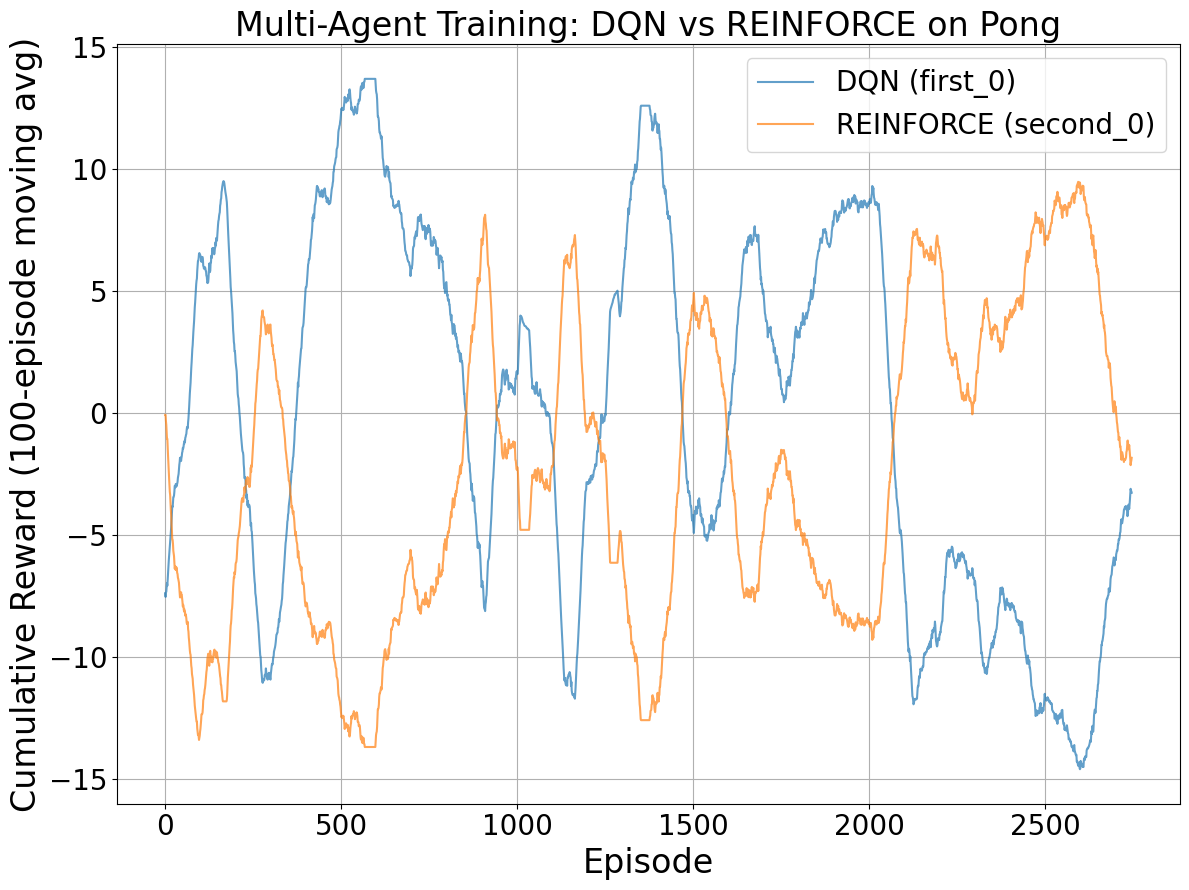

In [ ]:
plt.figure(figsize=(12, 9))

plt.plot(dqn_rewards_smooth, label="DQN (first_0)", alpha=0.7)
plt.plot(reinforce_rewards_smooth, label="REINFORCE (second_0)", alpha=0.7)

plt.xlabel("Episode", fontsize=24)
plt.ylabel("Cumulative Reward (100-episode moving avg)", fontsize=24)
plt.title("Multi-Agent Training: DQN vs REINFORCE on Pong", fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import cv2
import os

def make_eval_env():
    env = pong_v3.env(render_mode="human")
    env = ss.color_reduction_v0(env, mode='full')
    env = ss.resize_v1(env, x_size=84, y_size=84)
    env = ss.frame_skip_v0(env, 4)
    env = ss.frame_stack_v1(env, stack_size=4)
    return env

def evaluate_and_save_video(env_fn, dqn_agent, reinforce_agent, video_path="evaluation_output.mp4", fps=30):
    env = env_fn()
    frames = []

    env.reset()

    for agent in env.agent_iter():
        obs, reward, termination, truncation, _ = env.last()
        done = termination or truncation

        if not done:
            if agent == "first_0":
                action = dqn_agent.select_action(obs, epsilon=0.1)
            elif agent == "second_0":
                action = reinforce_agent.select_action(obs)
            env.step(action)
        else:
            env.step(None)

        frame = env.render()
        if frame is not None:
            frames.append(frame)

    env.close()

    # Save video
    if len(frames) > 0:
        height, width, _ = frames[0].shape
        out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))
        for f in frames:
            f_bgr = cv2.cvtColor(f, cv2.COLOR_RGB2BGR)
            out.write(f_bgr)
        out.release()
        print(f"Video saved to {video_path}")
    else:
        print("No frames captured — something went wrong.")

evaluate_and_save_video(make_eval_env, dqn_agent, reinforce_agent, video_path="pong_agents.mp4", fps=30)

⚠️ No frames captured — something went wrong.


In [ ]:
def make_eval_env():
    env = pong_v3.env(render_mode="rgb_array")
    env = ss.color_reduction_v0(env, mode='full')
    env = ss.resize_v1(env, x_size=84, y_size=84)
    env = ss.frame_skip_v0(env, 4)
    env = ss.frame_stack_v1(env, stack_size=4)
    return env

def evaluate_agents(env_fn, dqn_agent, reinforce_agent, num_episodes=10):
    dqn_rewards = []
    reinforce_rewards = []
    episode_lengths = []

    for episode in range(num_episodes):
        env = env_fn()
        env.reset()

        ep_dqn_reward = 0
        ep_reinforce_reward = 0
        frame_count = 0

        for agent in env.agent_iter():
            obs, reward, termination, truncation, _ = env.last()
            done = termination or truncation

            if not done:
                if agent == "first_0":
                    action = dqn_agent.select_action(obs, epsilon=0.1)  # Greedy
                elif agent == "second_0":
                    action = reinforce_agent.select_action(obs)
                env.step(action)
            else:
                env.step(None)

            if agent == "first_0":
                ep_dqn_reward += reward
            elif agent == "second_0":
                ep_reinforce_reward += reward

            frame_count += 1

        dqn_rewards.append(ep_dqn_reward)
        reinforce_rewards.append(ep_reinforce_reward)
        episode_lengths.append(frame_count)
        env.close()

    return dqn_rewards, reinforce_rewards, episode_lengths

def moving_average(data, window_size=20):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_evaluation(dqn_rewards, reinforce_rewards, episode_lengths):
    dqn_avg = moving_average(dqn_rewards, 20)
    reinforce_avg = moving_average(reinforce_rewards, 20)
    lengths_avg = moving_average(episode_lengths, 20)

    fig, ax = plt.subplots(figsize=(12, 10))
    ax.plot(dqn_avg, label="DQN Reward (20-ep avg)")
    ax.plot(reinforce_avg, label="REINFORCE Reward (20-ep avg)")
    ax.set_xlabel("Episode", fontsize=24)
    ax.set_ylabel("Total Reward", fontsize=24)
    ax.set_title("Agent Rewards per Episode", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.grid(True)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.40), fontsize=20, ncol=2)
    plt.tight_layout(rect=[0, 0.15, 1, 1])
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 10))
    ax.plot(lengths_avg, label="Episode Length (20-ep avg)")
    ax.set_xlabel("Episode", fontsize=24)
    ax.set_ylabel("Frame Count", fontsize=24)
    ax.set_title("Episode Duration (Competitiveness)", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.grid(True)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.40), fontsize=20)
    plt.tight_layout(rect=[0, 0.15, 1, 1])
    plt.show()


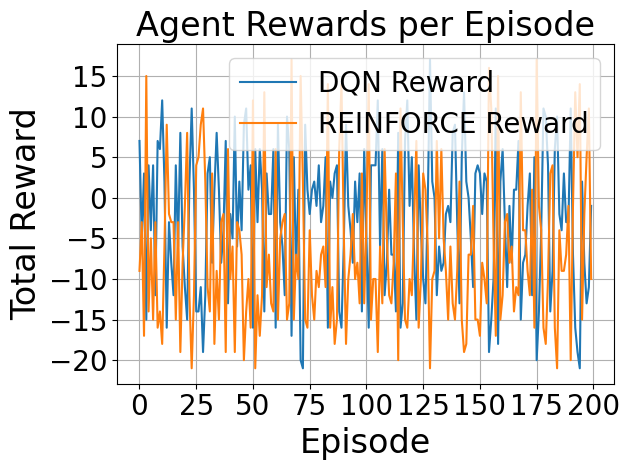

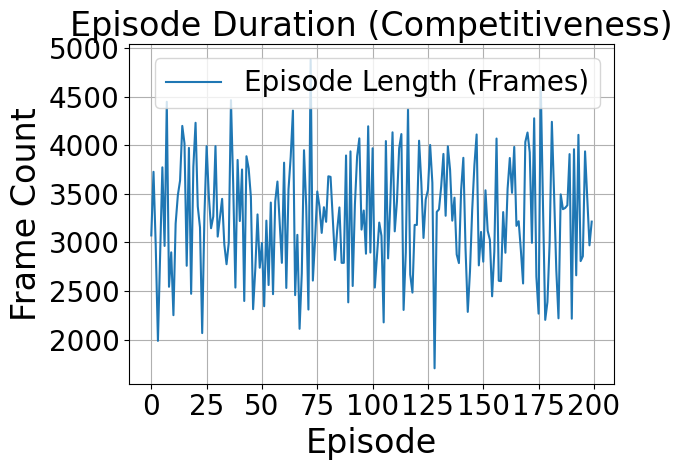

In [ ]:
dqn_rewards, reinforce_rewards, episode_lengths = evaluate_agents(
    make_eval_env, dqn_agent, reinforce_agent, num_episodes=200
)



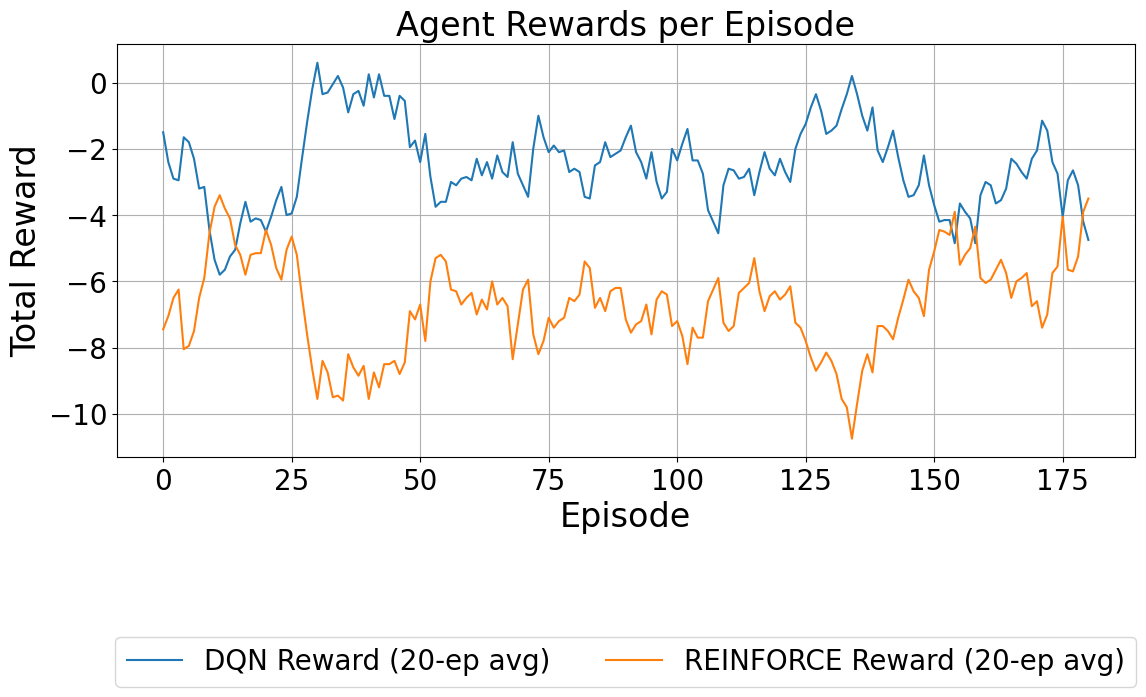

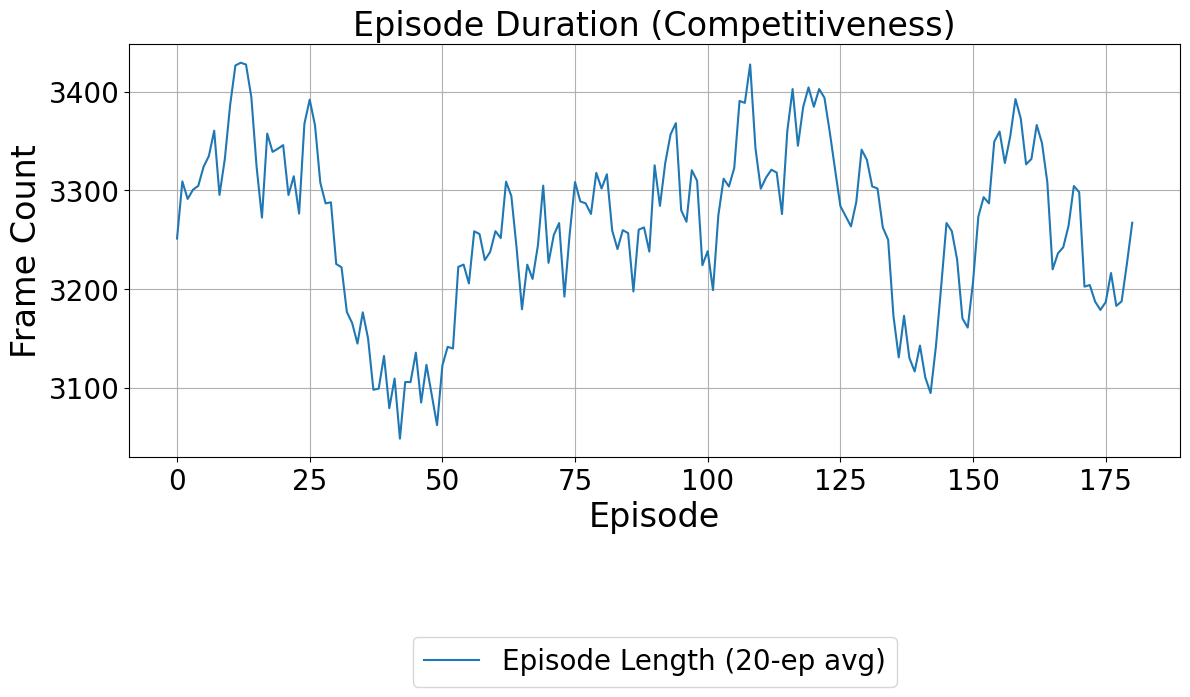

In [ ]:
plot_evaluation(dqn_rewards, reinforce_rewards, episode_lengths)

In [ ]:
import numpy as np

class RandomAgent:
    def select_action(self, obs, epsilon=0.0):
        return np.random.randint(0, 6)


In [ ]:
random_rewards_1, random_rewards_2, random_lengths = evaluate_agents(
    make_eval_env,
    RandomAgent(),
    RandomAgent(),
    num_episodes=200
)


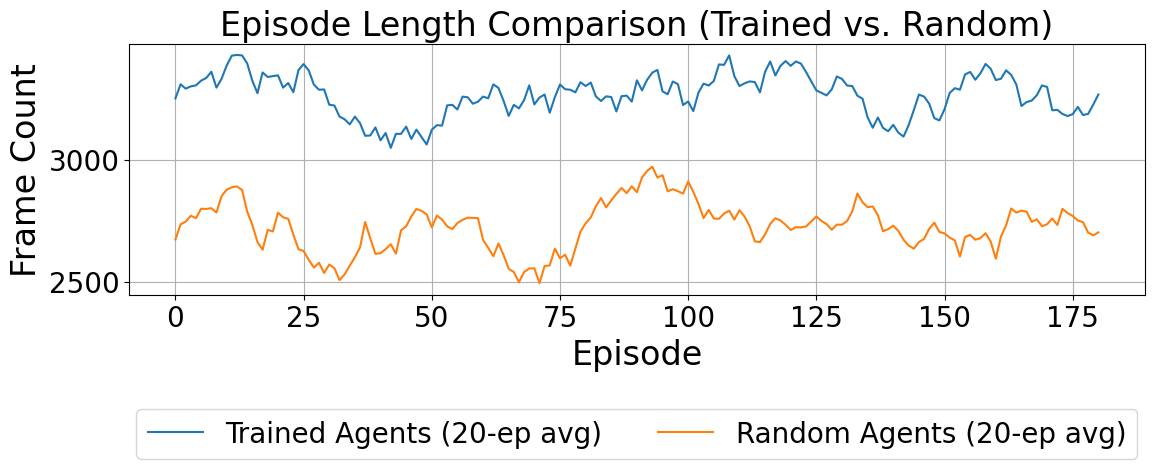

In [ ]:
def moving_average(data, window_size=20):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_length_comparison(episode_lengths, random_lengths):
    trained_avg = moving_average(episode_lengths, 20)
    random_avg = moving_average(random_lengths, 20)

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(trained_avg, label="Trained Agents (20-ep avg)")
    ax.plot(random_avg, label="Random Agents (20-ep avg)")
    ax.set_xlabel("Episode", fontsize=24)
    ax.set_ylabel("Frame Count", fontsize=24)
    ax.set_title("Episode Length Comparison (Trained vs. Random)", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.grid(True)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.40), fontsize=20, ncol=2)

    plt.tight_layout(rect=[0, 0.15, 1, 1])
    plt.show()

plot_length_comparison(episode_lengths, random_lengths)

In [ ]:
print(f"Average episode length (trained): {np.mean(episode_lengths):.2f} frames")
print(f"Average episode length (random): {np.mean(random_lengths):.2f} frames")